<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/fly_eye_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
col = ['TIMESTAMP', '"RECORD"', '"rtime"', '"batt_volt"', '"panel_temp"', '"CM3Up_mv_Avg"', '"CM3Up_Wm2_Avg"', '"CMP21_Avg"', '"CMP21_Wm2_Avg"', '"CelSol_01_Avg"', '"CelSol_02_Avg"', '"CelSol_03_Avg"', '"CelSol_04_Avg"', '"CelSol_05_Avg"', '"CelSol_06_Avg"', '"CelSol_07_Avg"', '"CelSol_08_Avg"', '"CelSol_09_Avg"', '"CelSol_10_Avg"', '"CelSol_11_Avg"', '"CelSol_12_Avg"', '"CelSol_13_Avg"', '"CelSol_14_Avg"', '"CelSol_15_Avg"', '"CelSol_16_Avg"', '"CelSol_17_Avg"']
labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/plataforma/LBM_solar_2022.dat',sep=';', header=None,skiprows=lambda x:x in [0,1,2,3], names=col)
labmim[col] = labmim.TIMESTAMP.str.split(",", expand = True)

In [4]:
def calcular_nan():
  count = labmim.isna().any(axis=1).sum()
  print(f"Number of rows with at least one NaN value: {count}")
  print(f"Total rows in series: {len(labmim)}")
calcular_nan()

Number of rows with at least one NaN value: 0
Total rows in series: 459301


### Organização dos valores
##### Sequenciamento dos valores e suas respectivas coordenadas bidimensionais em duas litas separadas 

In [5]:
sensors=col[9:]
labmim_backup = labmim

for i in sensors:
  x=0
  unique_types = set()
  #for item in labmim_backup[i]:
  #  unique_types.add(type(item))
  #print(unique_types)
  labmim_backup[i] = [int(x) if str(x).isdigit() else 0 for x in labmim_backup[i]]

In [6]:
#@markdown #### Função para separar valores (soma, média d.m., média h.m, etc)
#@markdown **gerar_valores(tabela, var)**
sensors=col[9:]

def gerar_valores(tabela,var):
  values=[]
  if var==0: #@markdown - 0 = Soma de todos os valores da série
    for i in sensors:
      values.append(sum(labmim_backup[i]))
    final = [values[0:8],values[8:16],[values[16]]*8]
    return final
gerar_valores(labmim_backup, 0)

[[9193338, 8456400, 7708758, 6284256, 5188114, 8744490, 6627322, 8936112],
 [9984239, 9424400, 8200163, 7292308, 9630627, 9153611, 5179864, 10811614],
 [8548850, 8548850, 8548850, 8548850, 8548850, 8548850, 8548850, 8548850]]

In [7]:
#@markdown ### Formação das novas coordenadas para a interpolação
#@markdown - Matriz 30x100 replicada à esquerda e direita, resultando em uma matriz 30x300
#@markdown - Ao fim, será extraído uma matriz a partir do meio, com dimensões 30x100
pol = []
colunas_i=[10,21,31,41,52,62,72,83,114,124,134,145,155,166,176,186,217,228,238,248,259,269,279,290]
for u in [5,3,1]:
  p = []
  for v in colunas_i:
    p.append([u,v])
  pol.append(p)
pd.DataFrame(pol)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"[5, 10]","[5, 21]","[5, 31]","[5, 41]","[5, 52]","[5, 62]","[5, 72]","[5, 83]","[5, 114]","[5, 124]",...,"[5, 176]","[5, 186]","[5, 217]","[5, 228]","[5, 238]","[5, 248]","[5, 259]","[5, 269]","[5, 279]","[5, 290]"
1,"[3, 10]","[3, 21]","[3, 31]","[3, 41]","[3, 52]","[3, 62]","[3, 72]","[3, 83]","[3, 114]","[3, 124]",...,"[3, 176]","[3, 186]","[3, 217]","[3, 228]","[3, 238]","[3, 248]","[3, 259]","[3, 269]","[3, 279]","[3, 290]"
2,"[1, 10]","[1, 21]","[1, 31]","[1, 41]","[1, 52]","[1, 62]","[1, 72]","[1, 83]","[1, 114]","[1, 124]",...,"[1, 176]","[1, 186]","[1, 217]","[1, 228]","[1, 238]","[1, 248]","[1, 259]","[1, 269]","[1, 279]","[1, 290]"


In [13]:
from scipy.interpolate import interp2d

# Definindo a matriz original
matriz_original = gerar_valores(labmim_backup, 0)
matriz_original = np.hstack((matriz_original,matriz_original,matriz_original))
coordenadas = np.array(pol)

# Definindo a grade da nova matriz
x_new = np.linspace(0, 299, 300)
y_new = np.linspace(0, 5, 6)
print(len(x_new))
print(len(y_new))

# Criando uma função interpoladora
f = interp2d(coordenadas[:, :, 1], coordenadas[:, :, 0], matriz_original, kind='cubic')

# Aplicando a função interpoladora na nova grade
nova_matriz_expandida = f(x_new, y_new)
nova_matriz = nova_matriz_expandida[:,100:200]


300
6


<ipython-input-13-0f4601d94b62>:15: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(coordenadas[:, :, 1], coordenadas[:, :, 0], matriz_original, kind='cubic')
<ipython-input-13-0f4601d94b62>:18: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

     

<ipython-input-16-15e97ef5125d>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('hot')


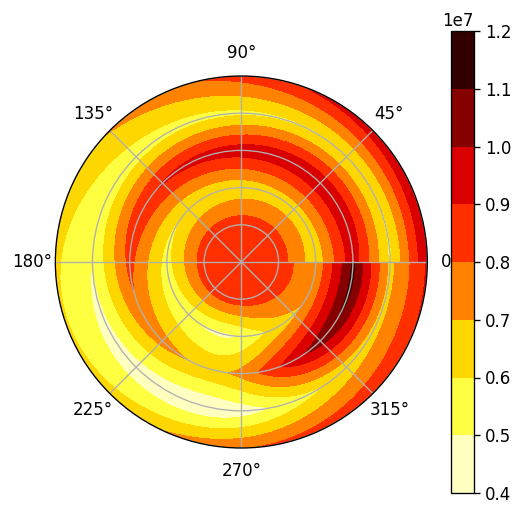

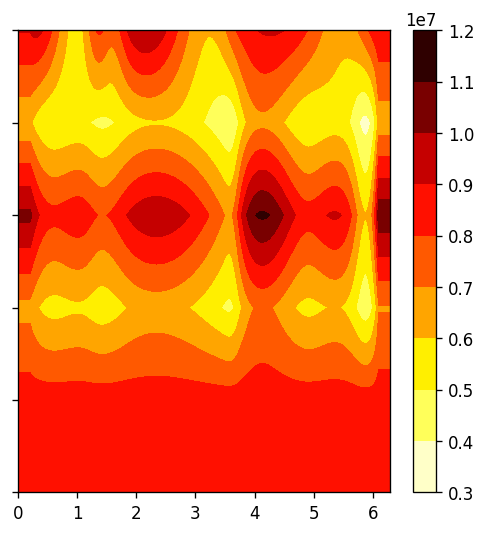

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

#fake data:
a = np.linspace(0,2*np.pi,100) # Sepação das partes em radianos
b = np.linspace(0,1,6) # Camadas por distancia ao centro
A, B = np.meshgrid(a, b)
c = nova_matriz

orig_map=plt.cm.get_cmap('hot')

#actual plotting
fig, ax = plt.subplots(figsize=(5,5),dpi=120,subplot_kw=dict(projection='polar'))
ax.set_yticklabels([])
ctf = ax.contourf(a, b, c, cmap=orig_map.reversed())
plt.colorbar(ctf)

fig, ax1 = plt.subplots(figsize=(5,5),dpi=120)
ax1.set_yticklabels([])
ctf = ax1.contourf(np.linspace(0,2*np.pi,300), b, nova_matriz_expandida, cmap=orig_map.reversed())
plt.colorbar(ctf)